### MODELS - STEP BY STEP:
 1. Load data - 15 Goyal-Welch predictors with 3 dependent variables : excess return, excess bond, HML

 2. Prepare data for modelling : split predictors for simple model, create random fourier features (12 000) for complex models - remember that at first use data up to december of 2020

 3. Start preparing models : window = 12, ridge_aplha = 1e3

 4. Calculate performance metrics: sharpe ratio, appraisal ratio, alpha t-stat and skewness for : Actual return, Return for the simple strategy and Return for complex strategy
 5. Create tables and plots showing similar results to those of AQR's article

 6. Add my own idea: simple way - add data up to 2023, hard way - consider making 2 models simple and complex using also more complex algorithm (probably a neural network), middle way - look at different ridge regularization parameters and different numbers of RFF (more complex analysis of complexity of models) or check different timing strategies

### Be careful of:
 - Data - I am 99% sure about the correctness of the predictors - all are available online and the author of the article said he's using them. Apart from HML we used data for dependent variables from different sources.

 - Models - Small changes in the process of model estimating change metrics by a noticeable amount
 
 - Performance Measures - Very important! I need to be sure of the correct calculation of SHARPE RATIO as it is the most important metric and whole analysis is based on it.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler
import statsmodels.api as sm
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

print(os.getcwd())
predictors = pd.read_excel("data_masters/predictors.xlsx")
dependent_vars = pd.read_excel("data_masters/dependent_vars.xlsx")

/Users/smigielski/Desktop/Master_thesis


### **Methodology**

In [2]:
window_size = 12
alpha = 1e3
gamma = 4

**Because the values we got from our analysis are different from the ones from the article (especially for US Stock Excess Return) I am not sure about the correctness of this methodology. I based it on this text from the article:**

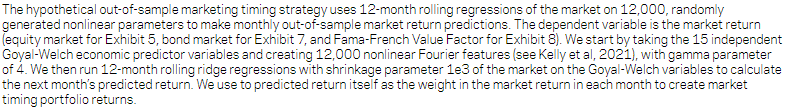

**Models**

- All models are made by using rolling regression
- Linear model: linear regression on the original predictors.
- Complex model: Ridge regression (alpha = 1e3) on the Random Fourier features.
- Predict the next month's returns using data from the previous 12 months.
- The dependent variables are not excess returns but the actual market returns (from various markets).
- Step by step, do what the author intended.

**Let's try to use the rolling regression from the internet**
- https://wire.insiderfinance.io/adaptive-time-series-forecasting-with-rolling-ridge-regression-a82f4a718471
- https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html

Complex Model - this is the important stuff

In [19]:
def complex_model(predictors, dependent_var):
    # Transform features using random Fourier features
    rbf_feature = RBFSampler(gamma=gamma, n_components=12000, random_state=42)
    fourier_features = rbf_feature.fit_transform(predictors)

    # Define Ridge Regression model
    ridge_model = Ridge(alpha=alpha)
    complex_predictions = []

    # Rolling window Ridge Regression
    for i in tqdm(range(window_size, len(predictors))):  # Include the last data point
        X_window = fourier_features[i-window_size:i]
        y_window = dependent_var[i-window_size:i]

        ridge_model.fit(X_window, y_window)  # Train model on current window
        X_next_scaled = fourier_features[i:i+1]  # Features for the next point
        prediction = ridge_model.predict(X_next_scaled)  # Predict next point
    
        complex_predictions.append(prediction[0])

    # Index predictions by corresponding dates (exclude initial window)
    predicted_dates = dependent_var.index[window_size:]
    complex_predictions = pd.Series(complex_predictions, index=predicted_dates)

    return complex_predictions

Simple Model

In [16]:
def linear_model(predictors, dependent_var):
    # Define Linear Regression model
    linear_model = LinearRegression()
    linear_predictions = []
    
    # Rolling window Linear Regression
    for i in tqdm(range(window_size, len(predictors))):  # Include the last data point
        X_window = predictors.iloc[i-window_size:i]
        y_window = dependent_var.iloc[i-window_size:i]
        
        linear_model.fit(X_window, y_window)  # Train model on current window
        X_next_scaled = predictors.iloc[i:i+1]  # Features for the next point
        prediction = linear_model.predict(X_next_scaled)  # Predict next point
    
        linear_predictions.append(prediction[0])
    
    # Index predictions by corresponding dates (exclude initial window)
    predicted_dates = dependent_var.index[window_size:]
    linear_predictions = pd.Series(linear_predictions, index=predicted_dates)

    return linear_predictions

**Market Timing Strategy**

- For each month, use the predicted return as the weight for the actual market return.
- Calculate portfolio returns as: predicted return × actual return.
- Create a series of portfolio returns over time.
- Ensure the author is calculating the returns correctly.

In [20]:
def timing_strategy(predictions,dependent_var):
    predicted_dates = dependent_var.index[window_size:]
    portfolio_returns = []
    for date in predicted_dates:
        
        actual_market_return = dependent_var.loc[date]
        predicted_market_return = predictions.loc[date]
    
        portfolio_return = predicted_market_return * actual_market_return
        portfolio_returns.append(portfolio_return)
    
    portfolio_returns = pd.Series(portfolio_returns, index=predicted_dates)

    return portfolio_returns

**Performance Measures**

- Sharpe Ratio: average excess return / standard deviation of portfolio returns.
- Appraisal Ratio: alpha / standard deviation of residuals (tracking error).
- Alpha t-stat: statistical significance of alpha.
- Skewness: skewness of the portfolio returns distribution.
- So, when calculating these metrics, you will need to compute excess returns.

In [6]:
def performance_measures(portfolio_returns, dependent_var, risk_free_rate):
    window = 12
    predicted_dates = dependent_var.index[window:]
    
    #Sharpe Ratio
    excess_returns = portfolio_returns  - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(portfolio_returns)

    #Appraisal Ratio (alpha Sharpe Ratio)
    X = sm.add_constant(dependent_var.loc[predicted_dates])
    y = portfolio_returns
    model = sm.OLS(y, X).fit()
    alpha = model.params[0] 
    residuals = model.resid 
    tracking_error = residuals.std()
    appraisal_ratio = alpha / tracking_error

    #Alpha t-stat
    alpha_t_stat = model.tvalues[0]
    
    #Skew
    skewness = skew(portfolio_returns)

    return sharpe_ratio, appraisal_ratio, alpha_t_stat, skewness

In [7]:
predictors

,yyyymm,dfy,infl,svar,d/e,lty,tms,tbl,corpr,d/p,d/y,ltr,e/p,ntis,lag_ret,b/p
0,192701,0.0095,-0.011299,0.000470,0.566884,0.0351,0.0028,0.0323,0.005600,0.052740,0.051646,0.007500,0.093036,0.050824,0.026047,2.253746
1,192702,0.0092,-0.005714,0.000287,0.577422,0.0347,0.0018,0.0329,0.006900,0.050816,0.053240,0.008800,0.088006,0.051668,-0.002910,2.333718
2,192703,0.0092,-0.005747,0.000924,0.587748,0.0331,0.0011,0.0320,0.008300,0.050969,0.051301,0.025300,0.086719,0.046357,0.045522,2.128723
3,192704,0.0090,0.000000,0.000603,0.598747,0.0333,-0.0006,0.0339,0.005500,0.050579,0.051450,-0.000500,0.084474,0.050514,0.007324,2.189362
4,192705,0.0093,0.005780,0.000392,0.609865,0.0327,-0.0006,0.0333,-0.001100,0.048511,0.051044,0.010900,0.079544,0.055275,0.013021,2.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,202308,0.0107,0.004367,0.001337,0.377320,0.0417,-0.0113,0.0530,-0.007769,0.015333,0.015061,-0.005182,0.040635,-0.016514,0.031700,4.741925
1160,202309,0.0103,0.002485,0.001023,0.376191,0.0438,-0.0094,0.0532,-0.026694,0.016164,0.015377,-0.022094,0.042968,-0.017989,-0.015424,4.576075
1161,202310,0.0102,-0.000383,0.001678,0.372471,0.0480,-0.0054,0.0534,-0.018726,0.016606,0.016241,-0.012083,0.044584,-0.014711,-0.047566,4.513986
1162,202311,0.0101,-0.002015,0.001341,0.368858,0.0450,-0.0077,0.0527,0.059782,0.015319,0.016685,0.034730,0.041531,-0.020618,-0.021040,4.909765


In [8]:
dependent_vars

,DATE,Mkt-RF,HML,GS10 (Bond)
0,192607,2.96,-2.43,NaN
1,192608,2.64,3.82,NaN
2,192609,0.36,0.13,NaN
3,192610,-3.24,0.70,NaN
4,192611,2.53,-0.51,NaN
...,...,...,...,...
1177,202408,1.61,-1.13,3.87
1178,202409,1.74,-2.59,3.72
1179,202410,-0.97,0.89,4.10
1180,202411,6.51,-0.05,4.36


In [9]:
predictors['date'] = pd.to_datetime(predictors['yyyymm'], format='%Y%m')
predictors = predictors.drop(columns = ['yyyymm'])
predictors.set_index('date', inplace=True)

predictors

,dfy,infl,svar,d/e,lty,tms,tbl,corpr,d/p,d/y,ltr,e/p,ntis,lag_ret,b/p
date,,,,,,,,,,,,,,,
1927-01-01,0.0095,-0.011299,0.000470,0.566884,0.0351,0.0028,0.0323,0.005600,0.052740,0.051646,0.007500,0.093036,0.050824,0.026047,2.253746
1927-02-01,0.0092,-0.005714,0.000287,0.577422,0.0347,0.0018,0.0329,0.006900,0.050816,0.053240,0.008800,0.088006,0.051668,-0.002910,2.333718
1927-03-01,0.0092,-0.005747,0.000924,0.587748,0.0331,0.0011,0.0320,0.008300,0.050969,0.051301,0.025300,0.086719,0.046357,0.045522,2.128723
1927-04-01,0.0090,0.000000,0.000603,0.598747,0.0333,-0.0006,0.0339,0.005500,0.050579,0.051450,-0.000500,0.084474,0.050514,0.007324,2.189362
1927-05-01,0.0093,0.005780,0.000392,0.609865,0.0327,-0.0006,0.0333,-0.001100,0.048511,0.051044,0.010900,0.079544,0.055275,0.013021,2.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.0107,0.004367,0.001337,0.377320,0.0417,-0.0113,0.0530,-0.007769,0.015333,0.015061,-0.005182,0.040635,-0.016514,0.031700,4.741925
2023-09-01,0.0103,0.002485,0.001023,0.376191,0.0438,-0.0094,0.0532,-0.026694,0.016164,0.015377,-0.022094,0.042968,-0.017989,-0.015424,4.576075
2023-10-01,0.0102,-0.000383,0.001678,0.372471,0.0480,-0.0054,0.0534,-0.018726,0.016606,0.016241,-0.012083,0.044584,-0.014711,-0.047566,4.513986


In [10]:
dependent_vars['date'] = pd.to_datetime(dependent_vars['DATE'], format='%Y%m')
dependent_vars = dependent_vars.drop(columns = ['DATE'])
dependent_vars.set_index('date', inplace=True)

dependent_vars

,Mkt-RF,HML,GS10 (Bond)
date,,,
1926-07-01,2.96,-2.43,NaN
1926-08-01,2.64,3.82,NaN
1926-09-01,0.36,0.13,NaN
1926-10-01,-3.24,0.70,NaN
1926-11-01,2.53,-0.51,NaN
...,...,...,...
2024-08-01,1.61,-1.13,3.87
2024-09-01,1.74,-2.59,3.72
2024-10-01,-0.97,0.89,4.10


### **Data Preparation**

In [11]:
market_return = dependent_vars['Mkt-RF']
bond_return = dependent_vars['GS10 (Bond)']
HML = dependent_vars['HML']
risk_free_rate = predictors['tbl']

### **Excess Market Return**

**Adjusting the dates**

In [12]:
market_return_predictors = predictors['1927-01-01':'2020-12-01']
market_return = market_return['1927-01-01':'2020-12-01']

**Simple Linear Model**

In [25]:
linear_predictions_market = linear_model(market_return_predictors,market_return)

portfolio_returns_simple_market = timing_strategy(linear_predictions_market,market_return)

sharpe_ratio_simple_market, appraisal_ratio_simple_market, alpha_t_stat_simple_market, skewness_simple_market = performance_measures(portfolio_returns_simple_market,market_return,risk_free_rate)

print(f'{sharpe_ratio_simple_market}      {appraisal_ratio_simple_market}       {alpha_t_stat_simple_market}      {skewness_simple_market}')

100%|██████████| 1116/1116 [00:02<00:00, 446.84it/s]

0.14462756847764302      0.13173880833197427       4.3660300062435615      -0.06468213627410503


**Complex Model**

In [21]:
complex_predictions_market = complex_model(market_return_predictors,market_return)

portfolio_returns_complex_market = timing_strategy(complex_predictions_market,market_return)

sharpe_ratio_complex_market, appraisal_ratio_complex_market, alpha_t_stat_complex_market, skewness_complex_market = performance_measures(portfolio_returns_complex_market,market_return,risk_free_rate)

print(f'{sharpe_ratio_complex_market}      {appraisal_ratio_complex_market}       {alpha_t_stat_complex_market}      {skewness_complex_market}')

100%|██████████| 1116/1116 [00:01<00:00, 675.92it/s]

0.04639577437014623      0.07049447632649807       2.3362971231706178      -4.391203311164725


**Reference values**

In [22]:
market_sharpe_ratio = np.mean(market_return) / np.std(market_return)
market_sharpe_ratio

0.12641849711516445

In [23]:
market_skew = skew(market_return)
market_skew

0.1704059710213811

### **Excess Return of 10Y Treasury Bond**

**Adjusting the dates (different from the article)**

In [27]:
bond_predictors = predictors['1953-04-01':'2020-12-01']
bond_return = bond_return['1953-04-01':'2020-12-01']

**Simple Linear Model**

In [28]:
linear_predictions_bond = linear_model(bond_predictors,bond_return)

portfolio_returns_simple_bond = timing_strategy(linear_predictions_bond,bond_return)

sharpe_ratio_simple_bond, appraisal_ratio_simple_bond, alpha_t_stat_simple_bond, skewness_simple_bond = performance_measures(portfolio_returns_simple_bond,bond_return,risk_free_rate)

print(f'{sharpe_ratio_simple_bond}      {appraisal_ratio_simple_bond}       {alpha_t_stat_simple_bond}      {skewness_simple_bond}')

100%|██████████| 801/801 [00:01<00:00, 446.43it/s]

0.959837210856247      -2.482539445809079       -31.66761713310566      2.2939279882661823


**Complex Model**

In [29]:
complex_predictions_bond = complex_model(bond_predictors,bond_return)

portfolio_returns_complex_bond = timing_strategy(complex_predictions_bond,bond_return)

sharpe_ratio_complex_bond, appraisal_ratio_complex_bond, alpha_t_stat_complex_bond, skewness_complex_bond = performance_measures(portfolio_returns_complex_bond,bond_return,risk_free_rate)

print(f'{sharpe_ratio_complex_bond}      {appraisal_ratio_complex_bond}       {alpha_t_stat_complex_bond}      {skewness_complex_bond}')

100%|██████████| 801/801 [00:01<00:00, 736.73it/s]


1.0101095706744976      -3.226318272624942       -41.155362900480135      1.8296704141470819


**Reference values**

In [30]:
excess_bond_return = bond_return - risk_free_rate['1953-04-01':'2020-12-01']

bond_sharpe_ratio = np.mean(excess_bond_return) / np.std(excess_bond_return)
bond_sharpe_ratio

1.9678553292187477

In [31]:
bond_skew = skew(excess_bond_return)
bond_skew

0.8461798126449531

### **HML**

**Adjusting the dates**

In [32]:
hml_predictors = predictors['1927-01-01':'2020-12-01']
HML = HML['1927-01-01':'2020-12-01']

**Simple Linear Model**

In [33]:
linear_predictions_hml = linear_model(hml_predictors,HML)

portfolio_returns_simple_hml = timing_strategy(linear_predictions_hml,HML)

sharpe_ratio_simple_hml, appraisal_ratio_simple_hml, alpha_t_stat_simple_hml, skewness_simple_hml = performance_measures(portfolio_returns_simple_hml,HML,risk_free_rate)

print(f'{sharpe_ratio_simple_hml}      {appraisal_ratio_simple_hml}       {alpha_t_stat_simple_hml}      {skewness_simple_hml}')

100%|██████████| 1116/1116 [00:02<00:00, 426.93it/s]

-0.0023305171787666      0.004473891487892156       0.14874426615843234      -7.614363853116946


**Complex Model**

In [34]:
complex_predictions_hml = complex_model(hml_predictors,HML)

portfolio_returns_complex_hml = timing_strategy(complex_predictions_hml,HML)

sharpe_ratio_complex_hml, appraisal_ratio_complex_hml, alpha_t_stat_complex_hml, skewness_complex_hml = performance_measures(portfolio_returns_complex_hml,HML,risk_free_rate)

print(f'{sharpe_ratio_complex_hml}      {appraisal_ratio_complex_hml}       {alpha_t_stat_complex_hml}      {skewness_complex_hml}')

100%|██████████| 1116/1116 [00:01<00:00, 738.10it/s]


0.06565821348681646      0.045230495523218506       1.5037863307125365      4.113155509437944


**Reference values**

In [35]:
excess_HML = HML - risk_free_rate['1927-01-01':'2020-12-01']

HML_sharpe_ratio = np.mean(excess_HML) / np.std(excess_HML)
HML_sharpe_ratio

0.0823680413619035

In [36]:
hml_skew = skew(excess_HML)
hml_skew

2.2018195475848046

### **Tables**

**Excess Market Return**

In [37]:
data_market = {
    'US Stocks Excess Return': [market_sharpe_ratio, None, None, market_skew],
    'Simple Linear Timing Strategy Return': [
        sharpe_ratio_simple_market,
        appraisal_ratio_simple_market,
        alpha_t_stat_simple_market,
        skewness_simple_market
    ],
    'Complex Nonlinear Timing Strategy Return': [
        sharpe_ratio_complex_market,
        appraisal_ratio_complex_market,
        alpha_t_stat_complex_market,
        skewness_complex_market
    ]
}

index = ['Sharpe Ratio', 'Appraisal Ratio', 'Alpha t-stat', 'Skew']

df_market = pd.DataFrame(data_market, index=index).style.format("{:.2f}").set_caption("Hypothetical Out-of-Sample Equity Market Timing Performance")

df_market

,US Stocks Excess Return,Simple Linear Timing Strategy Return,Complex Nonlinear Timing Strategy Return
Sharpe Ratio,0.13,0.14,0.05
Appraisal Ratio,nan,0.13,0.07
Alpha t-stat,nan,4.37,2.34
Skew,0.17,-0.06,-4.39


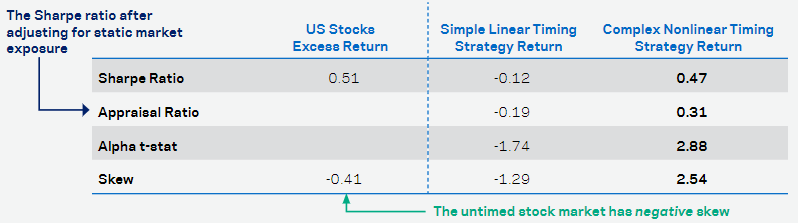

**Excess Bond Market Return**

In [38]:
data_bond = {
    'Bond Excess Return': [bond_sharpe_ratio, None, None, bond_skew],
    'Simple Linear Timing Strategy Return': [
        sharpe_ratio_simple_bond,
        appraisal_ratio_simple_bond,
        alpha_t_stat_simple_bond,
        skewness_simple_bond
    ],
    'Complex Nonlinear Timing Strategy Return': [
        sharpe_ratio_complex_bond,
        appraisal_ratio_complex_bond,
        alpha_t_stat_complex_bond,
        skewness_complex_bond
    ]
}

index_bond = ['Sharpe Ratio', 'Appraisal Ratio', 'Alpha t-stat', 'Skew']

df_bond = pd.DataFrame(data_bond, index=index_bond).style.format("{:.2f}").set_caption("Hypothetical Out-of-Sample Bond Timing Performance")

df_bond

,Bond Excess Return,Simple Linear Timing Strategy Return,Complex Nonlinear Timing Strategy Return
Sharpe Ratio,1.97,0.96,1.01
Appraisal Ratio,nan,-2.48,-3.23
Alpha t-stat,nan,-31.67,-41.16
Skew,0.85,2.29,1.83


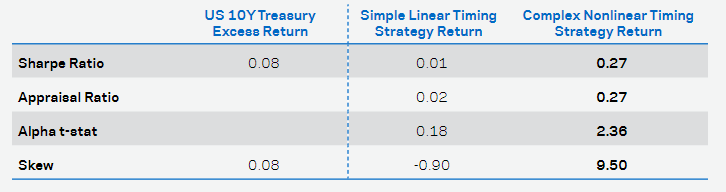

**HML Return**

In [39]:
data_hml = {
    'HML Excess Return': [HML_sharpe_ratio, None, None, hml_skew],
    'Simple Linear Timing Strategy Return': [
        sharpe_ratio_simple_hml,
        appraisal_ratio_simple_hml,
        alpha_t_stat_simple_hml,
        skewness_simple_hml
    ],
    'Complex Nonlinear Timing Strategy Return': [
        sharpe_ratio_complex_hml,
        appraisal_ratio_complex_hml,
        alpha_t_stat_complex_hml,
        skewness_complex_hml
    ]
}

index_hml = ['Sharpe Ratio', 'Appraisal Ratio', 'Alpha t-stat', 'Skew']

df_hml = pd.DataFrame(data_hml, index=index_hml).style.format("{:.2f}").set_caption("Hypothetical Out-of-Sample HML Timing Performance")

df_hml

,HML Excess Return,Simple Linear Timing Strategy Return,Complex Nonlinear Timing Strategy Return
Sharpe Ratio,0.08,-0.00,0.07
Appraisal Ratio,nan,0.00,0.05
Alpha t-stat,nan,0.15,1.50
Skew,2.20,-7.61,4.11


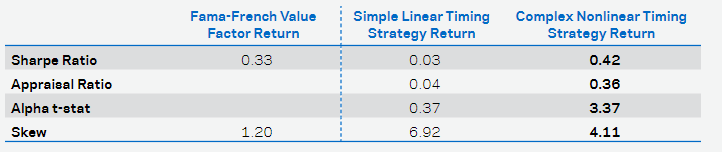